In [1]:
# from lfs_tree import *
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import pydot
import networkx as nx
from string import Template
import pandas as pd
import glob
import pydot
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import seaborn as sns
from matplotlib.lines import Line2D
from IPython.display import Image, display
import matplotlib.pyplot as plt
# from IPython.display import Image, display

# the graphs this script will generate:
## 1. local quality:
            x:  deletion_factor: fix user_input_size
            x:  complaint_ratio: fix user_input_size
            y:  fix rate + confirm preserve rate + global accuracy (before after)
## 2.3 strat comparison:
      x: user input size (fix complaint ratio, fix deletion factor)
      y: runtime, global_accuracy, fix rate, confirm preserve rate

In [2]:
line_color_assignment_dict={'naive':'g','information_gain':'r', 'optimal': 'b'}
scatter_shape_assignment_dict = {20: 'o', 40:'D', 80:'^', 160:'*', 320:'s'}

# 'o' - Circle (default)
# 's' - Square
# 'D' - Diamond
# '^' - Upward-pointing triangle
# 'v' - Downward-pointing triangle
# '<' - Left-pointing triangle
# '>' - Right-pointing triangle
# 'p' - Pentagon
# 'H' - Hexagon
# '+' - Plus sign
# '*' - Asterisk
# 'x' - X symbol
# '|' - Vertical bar
# '_' - Horizontal bar
# '.' - Point
# ',' - Pixel


In [3]:
# functions

def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

def show_trees(directory):
    treefiles = glob.glob(f'{directory}*tree_*')
    num_trees_per_strat = len(treefiles)
    for i in range(0, int(num_trees_per_strat)):
        for f in glob.glob(f'{directory}*tree_*_{i}*'):
            file = open(f)
            dot_string = file.read()
            print(f)
#             print(dot_string)
            graph = pydot.graph_from_dot_data(dot_string)[0]
            view_pydot(graph)
            print('\n')
            
def show_stats(directory):
    fs = glob.glob(f'{directory}*/*experiment_stats')
    df = pd.concat([pd.read_csv(f) for f in fs])
    return df

def determine_shape(x, shape_assignment_dict):
    return shape_assignment_dict[x]

def determine_color(x, color_assignment_dict):
    return color_assignment_dict[x]

def scatter_plots(df, x, y, xlabel, ylabel, title, shape_assignment_dict, color_assignment_dict,
                 first_legend_pos, second_legend_pos, strat_legend_rel_pos, ratio_legend_re_pos):
        
    fig, ax = plt.subplots()
    groups = df.groupby(['strat','complaint_ratio'])
    # Create a scatter plot for each group based on shape and color
    for (strat, ratio), group in groups:
        marker = shape_assignment_dict.get(strat)
        color=color_assignment_dict.get(ratio)
        ax.scatter(group[x], group[y], marker=marker, color=color, label=(strat, ratio))

    # Create separate shape and color legends
    legend_elements_1 = []
    legend_elements_2 = []

    for shape, marker in shape_assignment_dict.items():
        legend_elements_1.append(plt.Line2D([0], [0], marker=marker, color='w', label=shape, markerfacecolor='k'))
    for ratio, color in color_assignment_dict.items():
        legend_elements_2.append(plt.Line2D([0], [0], marker='o', color='w', label=ratio, markerfacecolor=color))

    # Add shape and color legends
    first_legend=ax.legend(handles=legend_elements_1, loc=first_legend_pos, 
                           bbox_to_anchor=strat_legend_rel_pos,
                           title='strategy', 
                           fontsize=13,title_fontsize=14)
    ax.legend(handles=legend_elements_2, loc=second_legend_pos, 
              bbox_to_anchor=ratio_legend_re_pos, title='complaint%',
              fontsize=13, title_fontsize=14)

    ax.add_artist(first_legend)

    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=14)

    plt.show()
    plt.close(fig)
    

def scatter_plot_single_group_value(df, x, y, xlabel, ylabel, title, color_assignment_dict, group_col,
                                   scale, xticks=[], yticks=[]):
    fig, ax = plt.subplots()
    groups = df.groupby([group_col])
    for (g), group in groups:
        color = color_assignment_dict.get(g)
        ax.scatter(group[x], group[y], color=color, label=(g), s=10)  # Set linestyle to an empty string
    if(ylabel=='new_global_accuracy'):
        ax.plot(df[x], df['global_accuracy'], color='black', label='accuracy_before_fix')
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=14)
    ax.set_yscale(scale)  # Set the y-axis to logarithmic scale
    if(yticks):
        ax.set_yticks(yticks)
    if(xticks):
        ax.set_xticks(xticks)
    # Customize y-axis ticks and labels
#     ax.set_yticks([0.1, 1, 10, 100])
#     ax.set_yticklabels(['10^-1', '10^0', '10^1', '10^2'])
    ax.legend(fontsize=13,title_fontsize=14)
    plt.savefig(f'graph_pdfs/{title}.pdf', format='pdf')
    
    plt.show()
    plt.close(fig)
    plt.show()
    plt.close(fig)

    
def boxplot(df, x, y, xlabel, ylabel, title, yscale=[], xscale=[], yticks=[], xticks=[]):
    plt.figure(figsize=(8, 6))
    
    # Set the y-axis scale
    strat_list = list(df['strat'].unique())
    strat_list.sort()
        
    ax = sns.boxplot(data=df, x=x, y=y, hue='strat', hue_order=strat_list)
        # Change tick label font size for both x and y axes
    ax.tick_params(axis='both', labelsize=12)
    
    # Add a horizontal line at the specified y-coordinate (line_y)
    if ylabel == 'new_global_accuracy':
#     if line_y is not None:
        ax.axhline(y=float(df['global_accuracy'].unique()[0]), color='red', label='gloabl accuracy before fix',
                  linewidth=5)
        ax.legend(fontsize=14,title_fontsize=15)
        # Create a separate legend for the box plot (customize as needed)
        box_legend = ax.legend(title='Strat',fontsize=13,title_fontsize=15)
    
        # Combine the legends
        ax.add_artist(box_legend)
    else:
        # Create a separate legend for the box plot (customize as needed)
        ax.legend(title='Strat',fontsize=14,title_fontsize=15)
    if yscale:
        ax.set_yscale(yscale)
    
    if xscale:
        ax.set_xscale(xscale)
    
    if yticks:
        ax.set_yticks(yticks)
    
    if xticks:
        ax.set_xticks(xticks)

    plt.title(title,fontsize=20)
    plt.xlabel(xlabel,fontsize=14)
    plt.ylabel(ylabel,fontsize=14)

    plt.savefig(f"graph_pdfs/box_{title}.pdf", format="pdf")
    plt.show()

def line_plots(df, x, y, xlabel, ylabel, title, color_assignment_dict,
               scatter_shape_assignment_dict,
               gtype='general',
               ylim=None,
              ):
    fig, ax = plt.subplots()
    groups = df.groupby(['strat', 'user_input_size'])
        
    unique_colors = set()  # Initialize sets to keep track of added labels
    unique_markers = set()
    color_legend_entries= []
    marker_legend_entries = []
    
    for (strat, size), group in groups:
#         print(f"strat:{strat}")
        color = color_assignment_dict.get(strat)
        if(color not in unique_colors):
            unique_colors.add(color)
            color_legend_entries.append(Line2D([0], [0], marker='s', color='w',
                                            markerfacecolor=color, markersize=10, label=strat))
        marker = scatter_shape_assignment_dict.get(size)
        if(marker not in unique_markers):
            unique_markers.add(marker)
#             print(marker)
            marker_legend_entries.append(Line2D([0], [0], marker=marker, color='w', 
                                            markerfacecolor='black', markersize=10, label=size))
        ax.scatter(group[x], group[y], color=color, label=size, marker=marker)

    for (strat, size), group in groups:
        color = color_assignment_dict.get(strat)
        ax.plot(group[x], group[y], color=color, label=strat)

    if(gtype=='accuracy'):
        ax.plot(df[x], df['global_accuracy'], color='blue', label='accuracy_before_fix')
    

    # Add the custom legends to the figure at desired locations within the axes
    fig.legend(handles=marker_legend_entries, loc='lower right', bbox_to_anchor=(0.85, 0.15),title='input size')
    fig.legend(handles=color_legend_entries, loc='upper right', bbox_to_anchor=(0.85, 0.85),title='strat')

    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=14)
    if(ylim):
        ax.set_ylim(ylim)
    plt.savefig(f'graph_pdfs/{title}.pdf', format='pdf')
    plt.show()
    plt.close(fig)
    


In [4]:
# 3 strat comparison

df_2_strats= show_stats('../experiment_results_folders/without_optimal/')
# /home/opc/author/RBBM/rbbm_src/experiment_results_folders

In [5]:
df_2_strats['confirm_preserve_rate']

0    1.000
0    0.833
0    1.000
0    1.000
0    1.000
0    1.000
0    1.000
0    1.000
0    1.000
0    1.000
0    1.000
0    1.000
0    0.643
0    0.714
0    1.000
0    1.000
0    1.000
0    1.000
0    1.000
0    1.000
0    1.000
0    1.000
0    1.000
0    1.000
0    1.000
0    0.667
0    1.000
0    1.000
0    0.167
0    0.167
0    0.667
0    0.667
0    1.000
0    1.000
0    0.500
0    0.500
0    1.000
0    1.000
0    1.000
0    1.000
0    1.000
0    1.000
0    0.972
0    0.972
0    1.000
0    0.833
0    0.972
0    0.972
0    0.964
0    1.000
0    0.964
0    0.893
0    0.857
0    0.929
0    0.929
0    0.929
0    1.000
0    1.000
0    0.900
0    0.900
0    1.000
0    1.000
0    0.900
0    0.900
0    1.000
0    0.917
0    0.333
0    0.333
0    0.667
0    0.750
0    0.917
0    0.917
0    1.000
0    1.000
0    1.000
0    1.000
0    0.750
0    0.750
0    1.000
0    1.000
0    0.986
0    1.000
0    0.736
0    0.806
0    0.875
0    0.875
0    0.903
0    0.903
0    1.000
0    1.000
0    0.964

In [6]:
df = df_2_strats[['strat','rbbm_runtime','bbox_runtime','deletion_factor','avg_tree_size_increase','user_input_size','complaint_ratio','global_accuracy','fix_rate','confirm_preserve_rate','new_global_accuracy']]
df_grouped = df.groupby(['strat','user_input_size', 'complaint_ratio', 'deletion_factor']).mean().reset_index()

In [7]:
deletion_factors = [0, 0.3, 0.5]
graphs_yaxis = ['new_global_accuracy', 'avg_tree_size_increase', 'fix_rate', 'confirm_preserve_rate', 'rbbm_runtime']

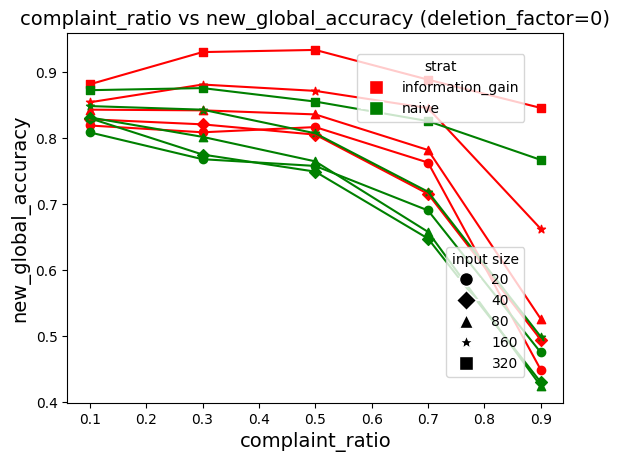

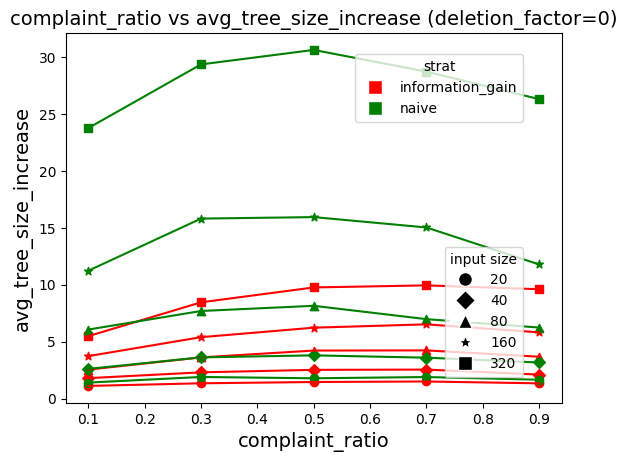

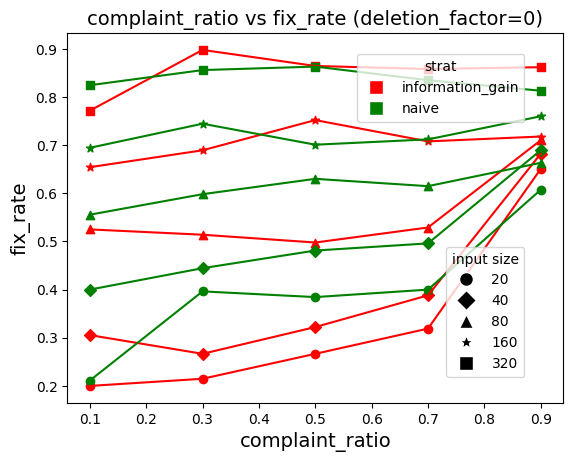

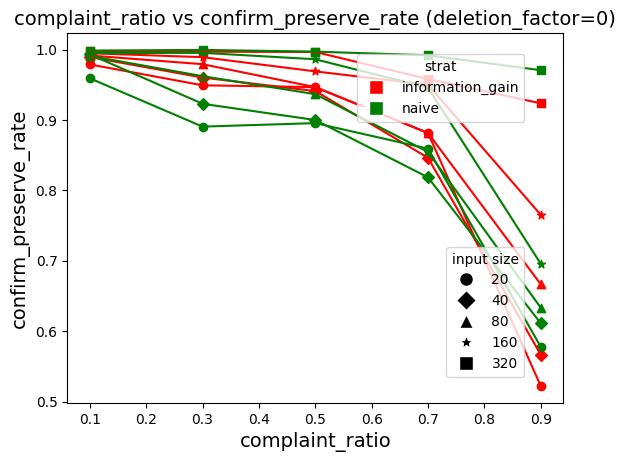

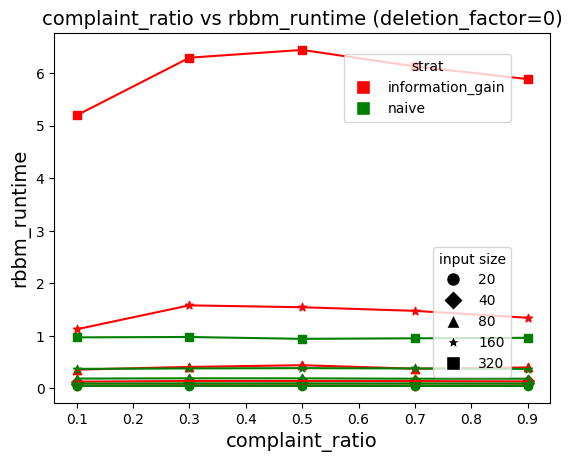

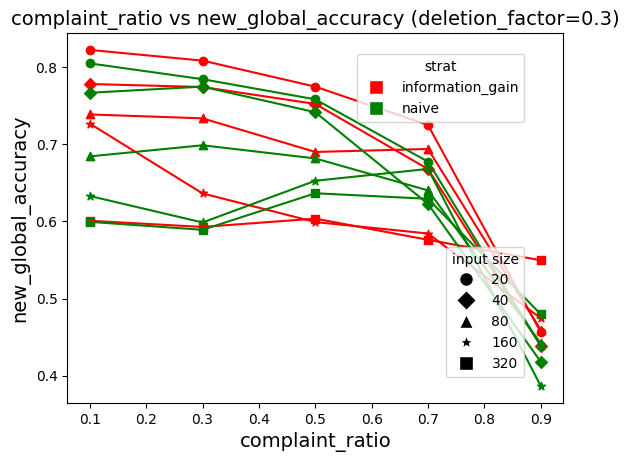

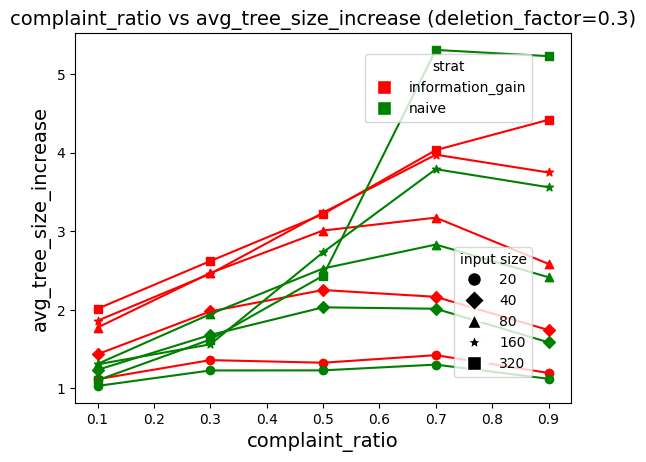

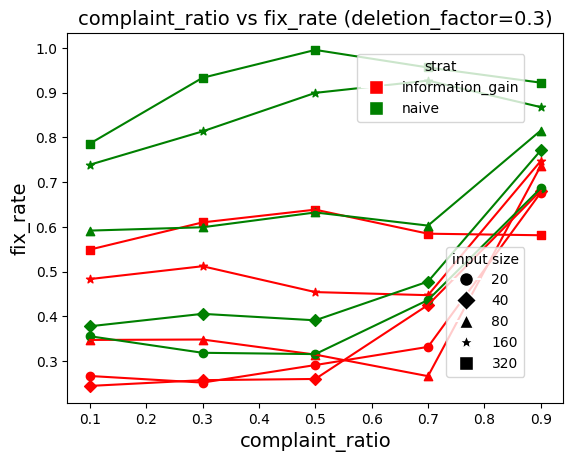

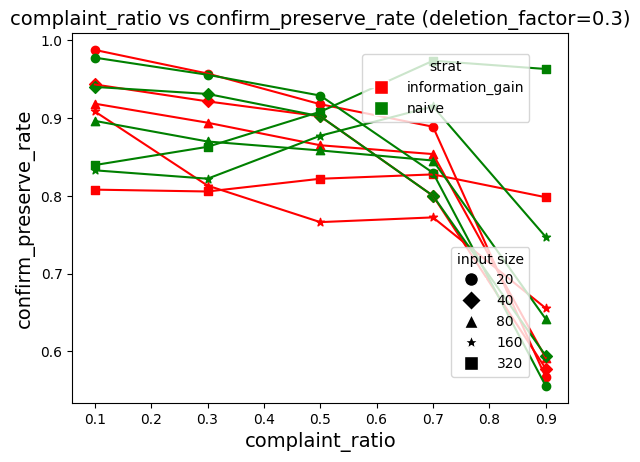

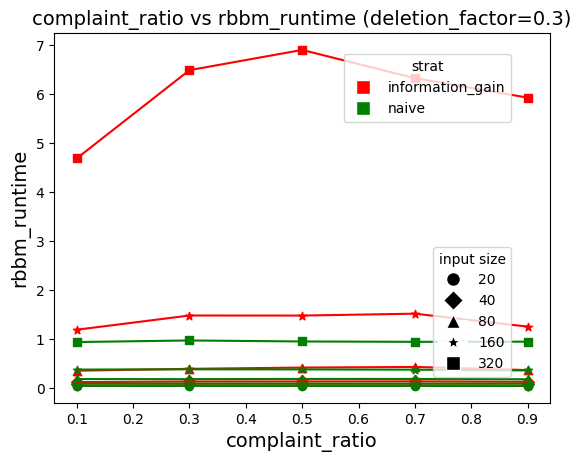

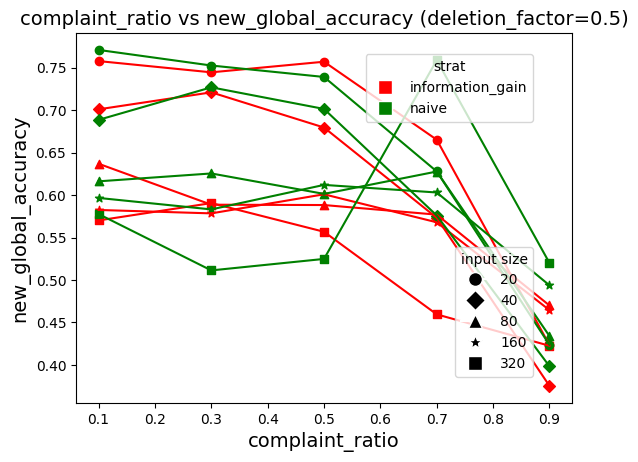

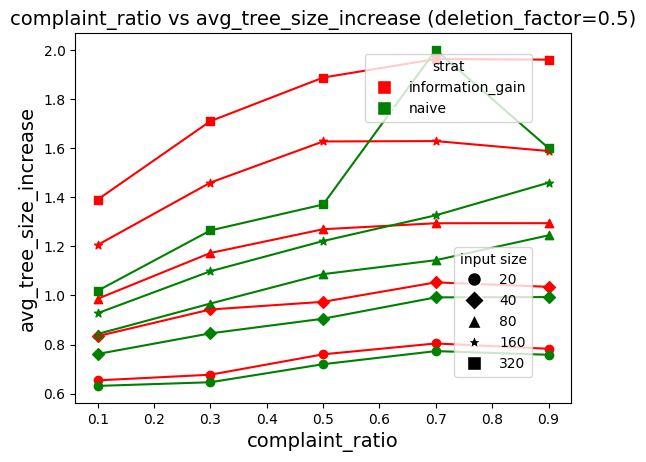

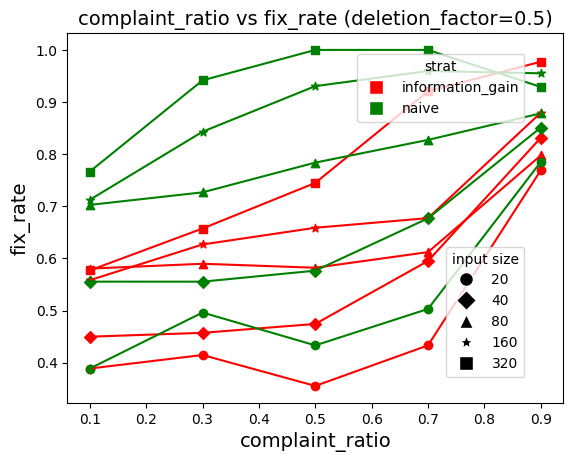

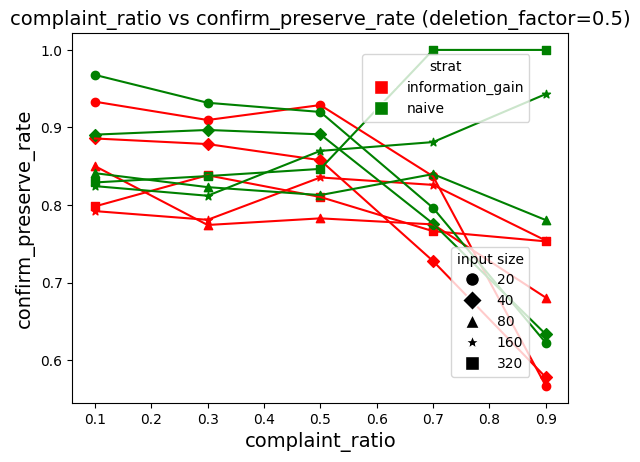

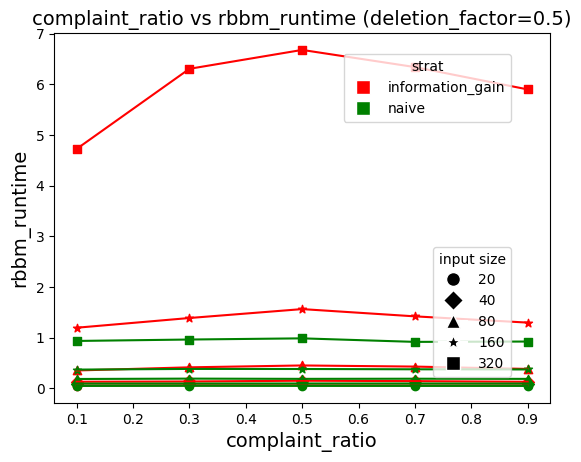

In [8]:
for del_f in deletion_factors:
    df_deletion_fixed = df_grouped[(df_grouped['deletion_factor']==del_f)]
    for y in graphs_yaxis:
        line_plots(df=df_deletion_fixed, 
        x='complaint_ratio', 
        y=y, 
        xlabel='complaint_ratio', 
        ylabel=y,
        title=f'complaint_ratio vs {y} (deletion_factor={del_f})', 
        color_assignment_dict=line_color_assignment_dict,
       scatter_shape_assignment_dict=scatter_shape_assignment_dict
       )

In [10]:
!zip graph_pdfs/fix_del_vary_complaint_rato.zip graph_pdfs/*

  adding: graph_pdfs/complaint_ratio vs avg_tree_size_increase (deletion_factor=0.3).pdf (deflated 35%)
  adding: graph_pdfs/complaint_ratio vs avg_tree_size_increase (deletion_factor=0.5).pdf (deflated 34%)
  adding: graph_pdfs/complaint_ratio vs avg_tree_size_increase (deletion_factor=0).pdf (deflated 34%)
  adding: graph_pdfs/complaint_ratio vs confirm_preserve_rate (deletion_factor=0.3).pdf (deflated 35%)
  adding: graph_pdfs/complaint_ratio vs confirm_preserve_rate (deletion_factor=0.5).pdf (deflated 35%)
  adding: graph_pdfs/complaint_ratio vs confirm_preserve_rate (deletion_factor=0).pdf (deflated 35%)
  adding: graph_pdfs/complaint_ratio vs fix_rate (deletion_factor=0.3).pdf (deflated 35%)
  adding: graph_pdfs/complaint_ratio vs fix_rate (deletion_factor=0.5).pdf (deflated 35%)
  adding: graph_pdfs/complaint_ratio vs fix_rate (deletion_factor=0).pdf (deflated 35%)
  adding: graph_pdfs/complaint_ratio vs new_global_accuracy (deletion_factor=0.3).pdf (deflated 35%)
  adding: grap